In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import tqdm

from au2v.analyst import Analyst
from au2v.config import ModelConfig, TrainerConfig
from au2v.dataset_manager import load_dataset_manager
from au2v.trainer import PyTorchTrainer
from au2v.model import load_model, PyTorchModel
from au2v import util
from au2v.util import to_full_meta_value

In [35]:
model_config = ModelConfig(
    max_embedding_norm=5,
)
trainer_config = TrainerConfig(
    dataset_name="movielens",
    model_name="attentive",
    load_dataset=False,
    save_dataset=False,
    load_model=False,
    ignore_saved_model=True,
    epochs=5,
)

In [36]:
dataset_manager = load_dataset_manager(
    dataset_name=trainer_config.dataset_name,
    dataset_dir=trainer_config.dataset_dir,
    load_dataset=trainer_config.load_dataset,
    save_dataset=trainer_config.save_dataset,
    window_size=model_config.window_size,
    data_dir="../data/"
)

dataset_manager does not exist at: cache/dataset/movielens.pickle, create dataset
num_seq: 6040, num_item: 3706, num_item_meta: 28, num_seq_meta: 30, num_item_meta_types: 3, num_seq_meta_types: 3


In [37]:
model = load_model(
    dataset_manager=dataset_manager,
    trainer_config=trainer_config,
    model_config=model_config
)

trainer = PyTorchTrainer(
    model=model,
    dataset_manager=dataset_manager,
    trainer_config=trainer_config,
    model_config=model_config,
)
trainer.fit()

  0%|          | 0/9207 [00:00<?, ?it/s]

100%|██████████| 9207/9207 [02:17<00:00, 66.90it/s]


train 0.004883000196118656


100%|██████████| 1728/1728 [00:09<00:00, 190.64it/s]


valid 0.004184902478724755
saved model to cache/model/movielens/attentive.pt


100%|██████████| 9207/9207 [02:19<00:00, 66.16it/s]


train 0.004035140814582733


100%|██████████| 1728/1728 [00:09<00:00, 188.28it/s]


valid 0.0039652712696548525
saved model to cache/model/movielens/attentive.pt


100%|██████████| 9207/9207 [02:21<00:00, 65.10it/s]


train 0.0038010135565717407


100%|██████████| 1728/1728 [00:09<00:00, 188.81it/s]


valid 0.003737644948721347
saved model to cache/model/movielens/attentive.pt


{'train': [0.004883000196118656, 0.004035140814582733, 0.0038010135565717407],
 'valid': [0.004184902478724755, 0.0039652712696548525, 0.003737644948721347]}

In [38]:
analyst = Analyst(
    dataset_manager=dataset_manager,
    model=trainer.model
)

In [39]:
plt.rcParams["font.size"] = 16

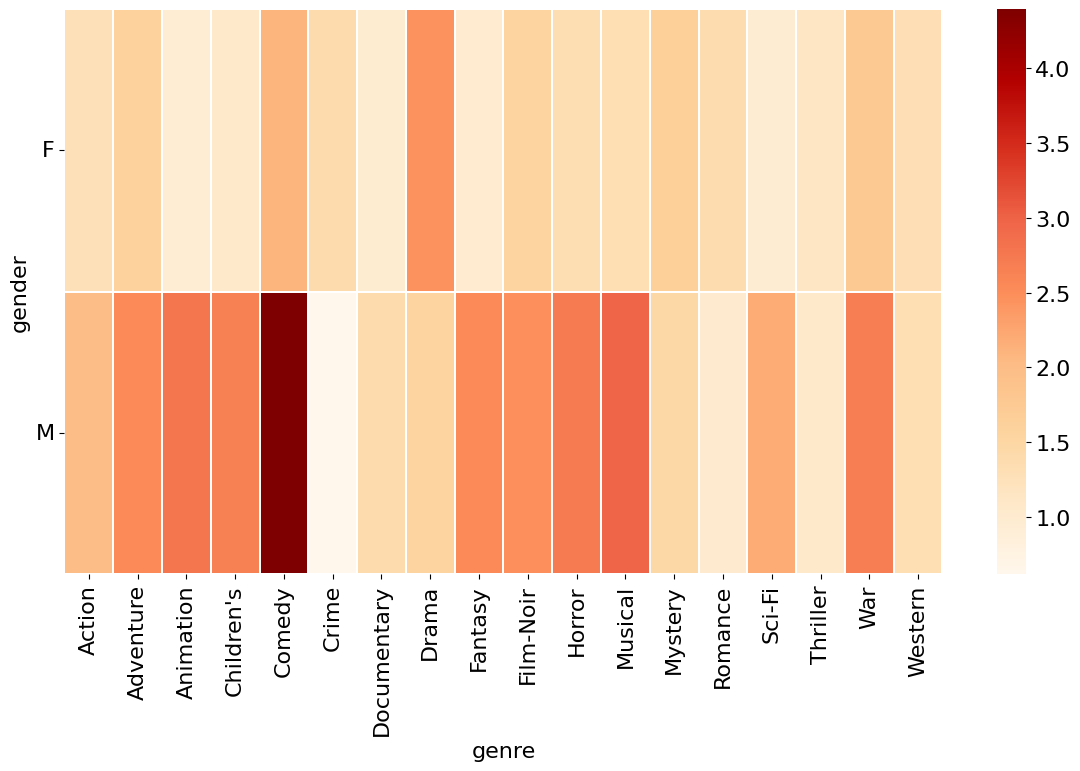

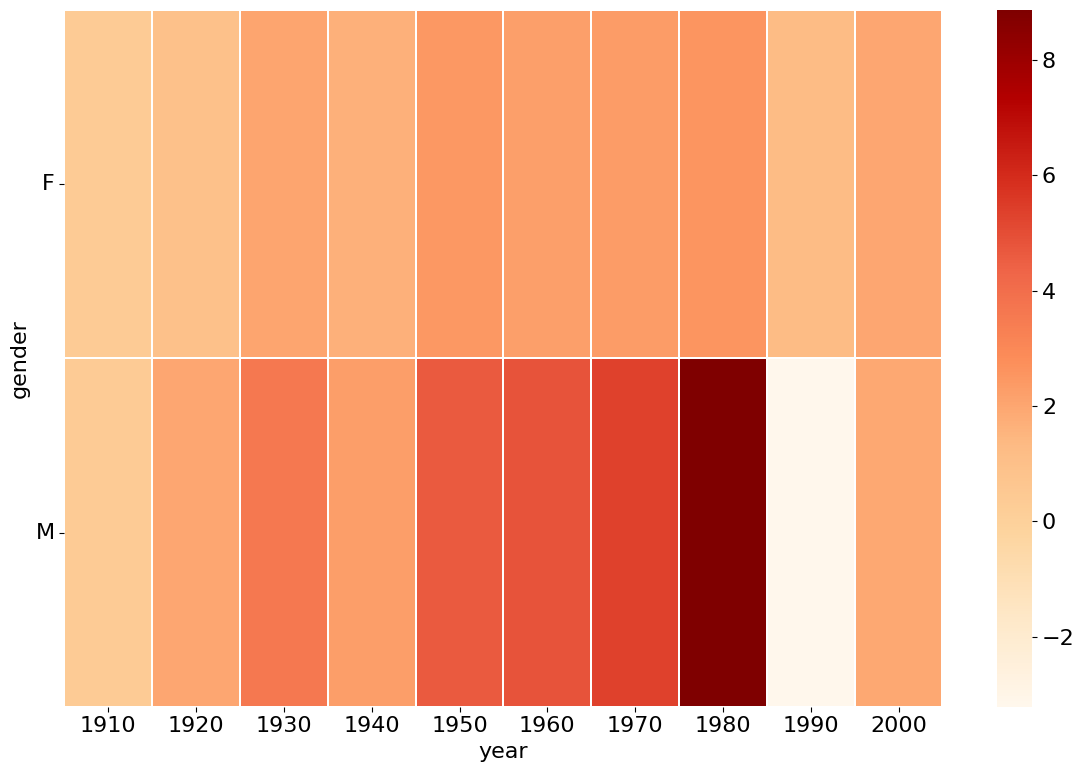

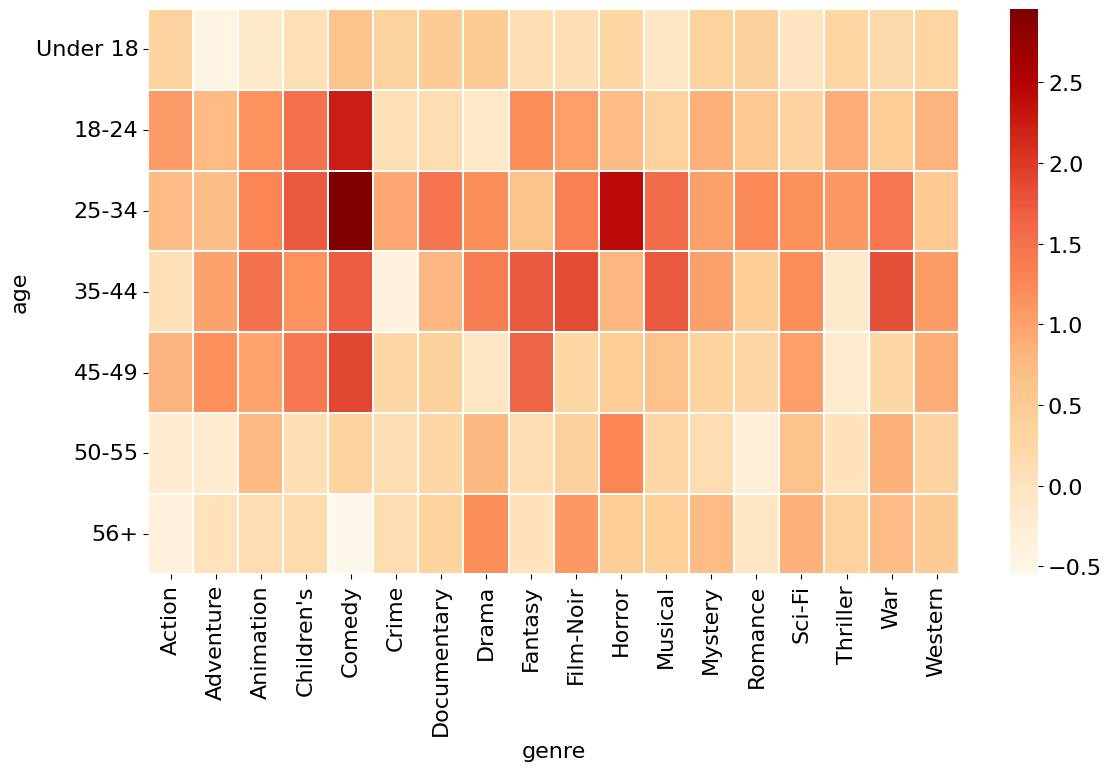

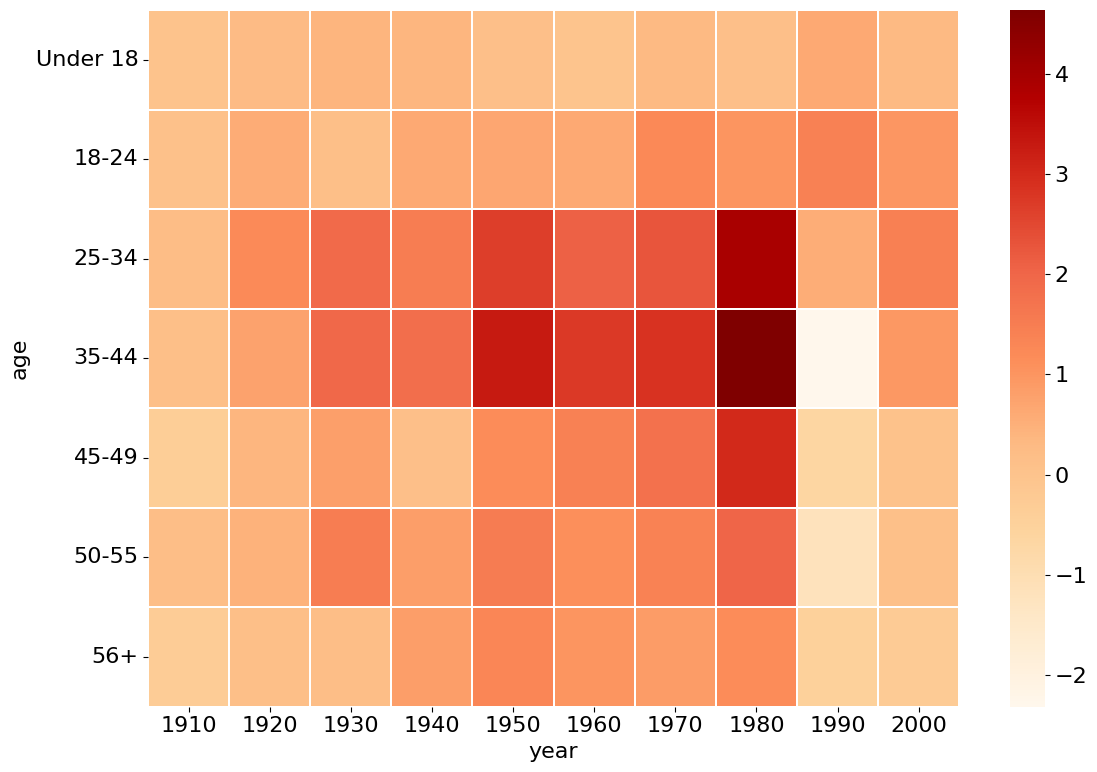

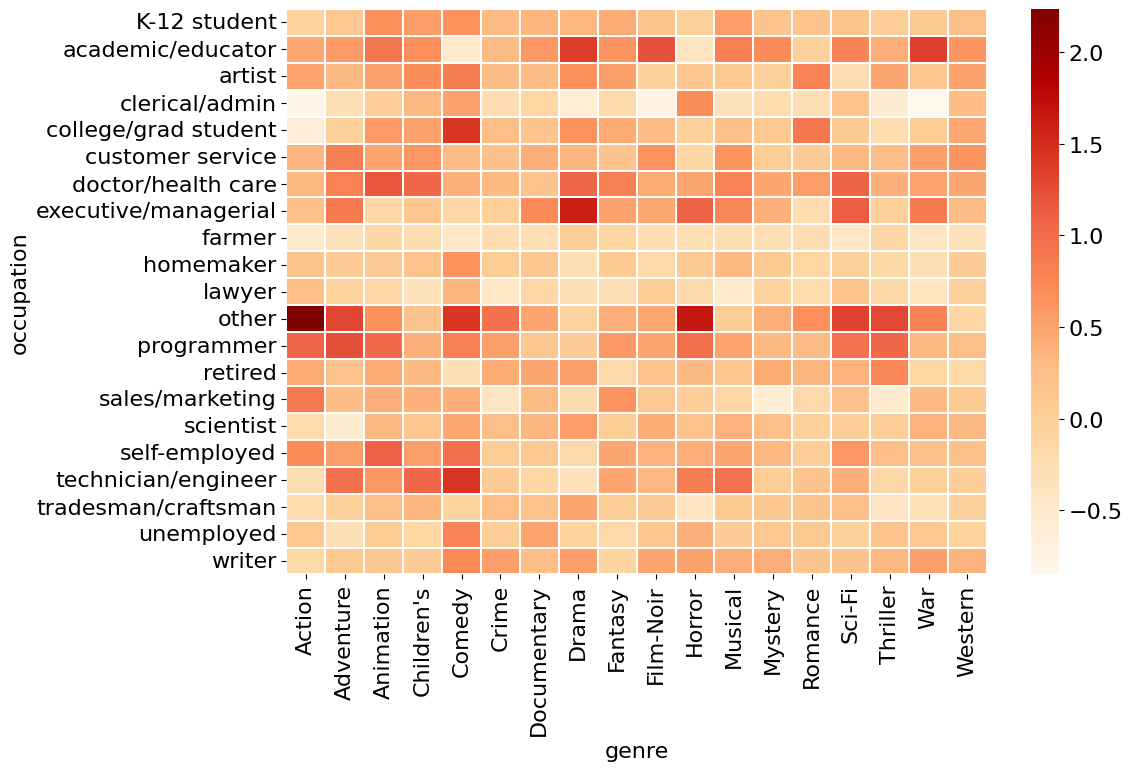

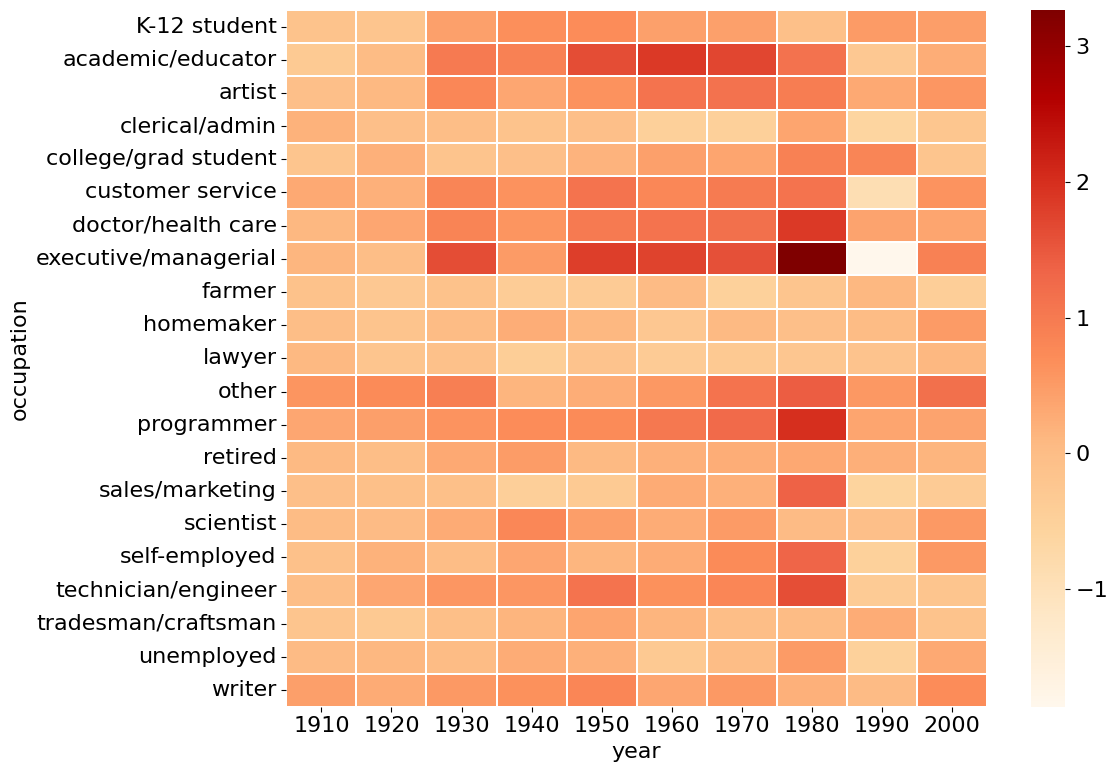

In [40]:
for seq_meta_name in [
    "gender",
    "age",
    "occupation",
]:
    for item_meta_name in [
        "genre",
        "year"
    ]:
        seq_meta_names = sorted([
            to_full_meta_value(seq_meta_name, e)
            for e in dataset_manager.seq_meta_dict[seq_meta_name]
        ])
        if seq_meta_name == "age":
            seq_meta_names = ["age:Under 18", "age:18-24", "age:25-34", "age:35-44", "age:45-49", "age:50-55", "age:56+"]
        item_meta_names = sorted([
            to_full_meta_value(item_meta_name, e)
            for e in dataset_manager.item_meta_dict[item_meta_name]
        ])

        data = np.zeros((len(seq_meta_names), len(item_meta_names)))
        for i, seq_key in enumerate(seq_meta_names):
            for j, item_key in enumerate(item_meta_names):
                data[i][j] = torch.dot(analyst.seq_meta_embedding[seq_key], analyst.item_meta_embedding[item_key])

        seq_keys = sorted(dataset_manager.seq_meta_dict[seq_meta_name])
        item_keys = sorted(dataset_manager.item_meta_dict[item_meta_name])
        if seq_meta_name == "age":
            seq_keys = ["Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"]

        fig, ax = util.visualize_heatmap(
            data,
            seq_keys,
            item_keys,
        )
        ax.set_ylabel(seq_meta_name)
        ax.set_xlabel(item_meta_name)

        fig.tight_layout()
        fig.savefig(f"./data/fig_heatmap_{seq_meta_name}_{item_meta_name}.pdf", format="pdf")

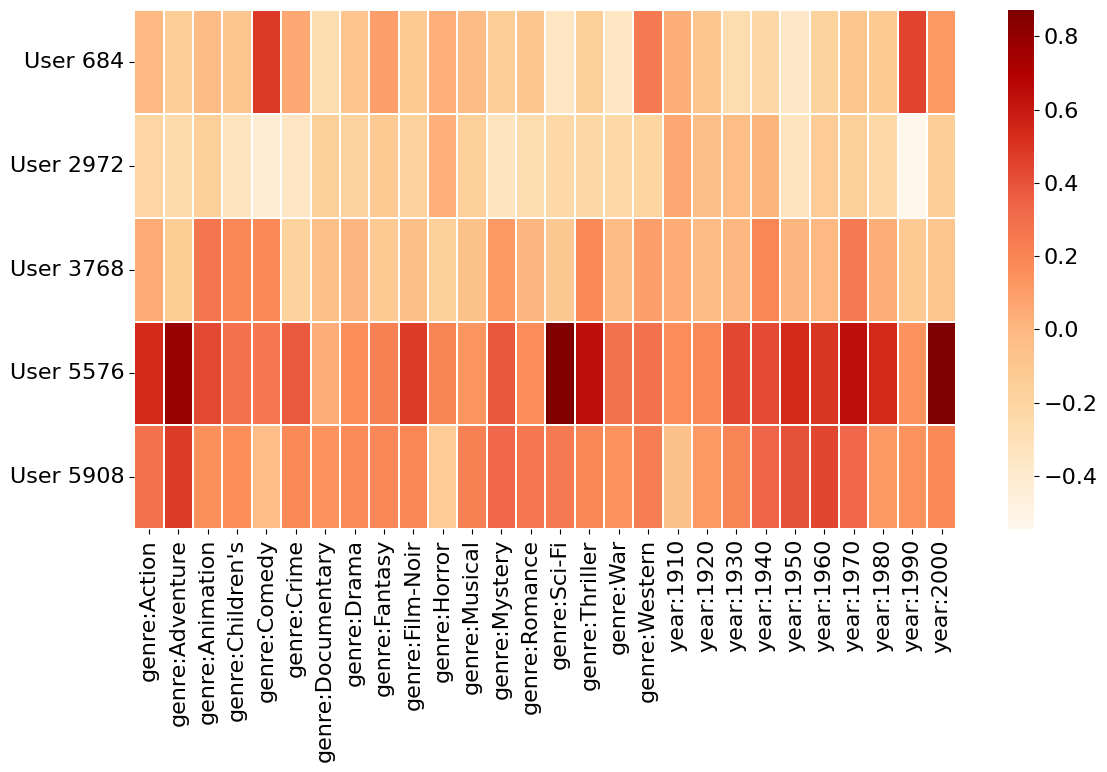

In [41]:
rnd = random.Random(42)

target_ids = []
for id, d in dataset_manager.seq_metadata.items():
    if d["gender"] == "M" and d["age"] == "25-34" and d["occupation"] == "college/grad student":
        target_ids.append(int(id))

rnd.shuffle(target_ids)

target_ids = sorted(target_ids[:5])
item_keys = dataset_manager.item_meta_le.classes_
seq_keys = list(map(lambda s: "User " + str(s), target_ids))

data = np.zeros((len(seq_keys), len(item_keys)))
for i, id in enumerate(target_ids):
    seq_index = dataset_manager.seq_le.transform([str(id)])[0]
    df = analyst.analyze_seq(seq_index)
    for j, item_key in enumerate(item_keys):
        data[i][j] = df[(df.seq == str(id)) & (df.item == item_key)].similarity.values[0]

fig, ax = util.visualize_heatmap(data, seq_keys, item_keys)
fig.tight_layout()
fig.savefig("data/fig_heatmap_user_item_meta.pdf")

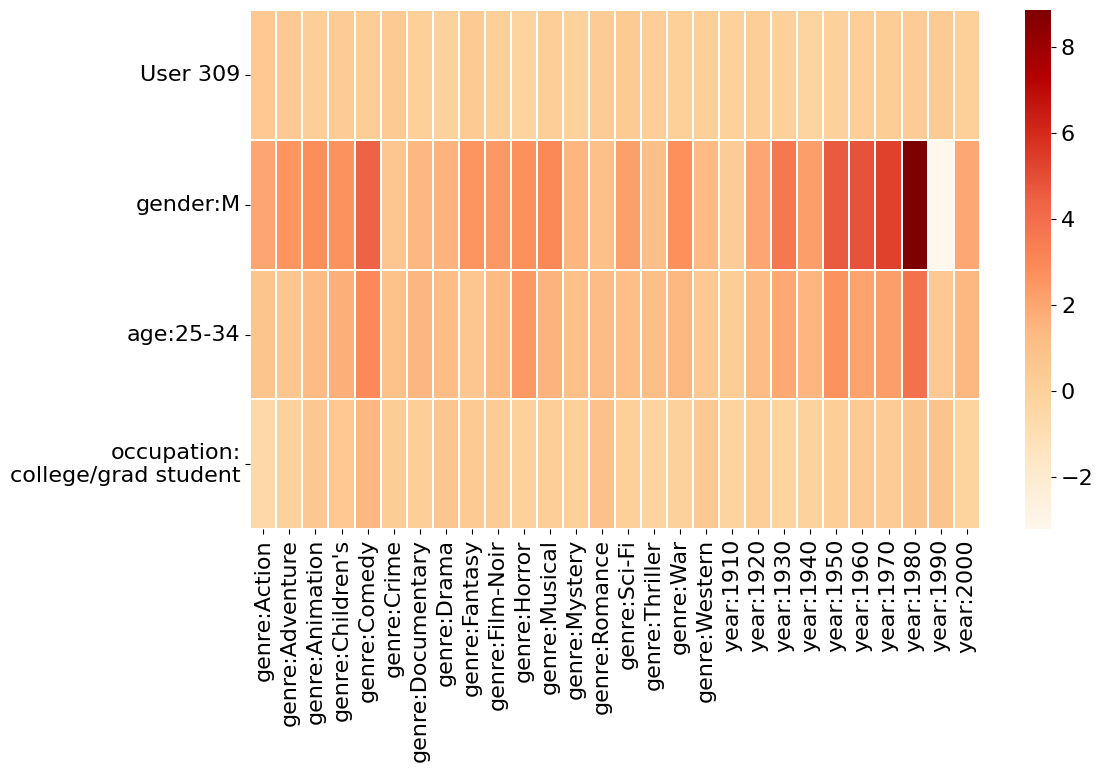

In [42]:
seq_keys = ["309", "gender:M", "age:25-34", "occupation:college/grad student"]
item_keys = dataset_manager.item_meta_le.classes_

df = analyst.analyze_seq(2323)

data = np.zeros((len(seq_keys), len(item_keys)))
for i, seq_key in enumerate(seq_keys):
    for j, item_key in enumerate(item_keys):
        data[i][j] = df[(df.seq == seq_key) & (df.item == item_key)].similarity.values[0]

seq_keys = ["User 309", "gender:M", "age:25-34", "occupation:\ncollege/grad student"]
fig, ax = util.visualize_heatmap(data, seq_keys, item_keys)
fig.tight_layout()
fig.savefig("data/fig_heatmap_user_all_item_meta.pdf")